# A person makes a doctor appointment, receives all the instructions and no-show. Who to blame?

The objective of this notebook is to produce an best model to predict an appointment's no-show, given a patient. The data set shows information of appointments in public hospitals in Vitoria, Espirito Santo, Brazil.

- The following steps will be followed:

- Univariate Analysis (with Feature Engineering)

- Significant Featuring (using corelation matrix and VIF)

- LogisticRegression (Hyperparameter Tuning)

- SVM
    - Hyperparamter Tuning

- DecisionTree Classifier and Boosting it. 
    - RandomForest (Hyperparameter Tuning)

- Models Analysis

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.svm  import LinearSVC,SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn import metrics,svm
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,roc_curve
from sklearn.model_selection import KFold,cross_val_score,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
import pickle

%matplotlib inline

In [4]:
df = pd.read_csv('./Data/KaggleV2-May-2016.csv')

### let see top five rows in data

In [5]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [6]:
df.shape

(110527, 14)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [8]:
df['PatientId'] = df['PatientId'].astype('int64')

Our index should be AppointmentID , has we are trying to show/noshow based on appointment number 

In [9]:
df.set_index('AppointmentID',inplace = True)

Number of Patients in total

In [10]:
df['PatientId'].unique().shape[0]

62299

Patients with more than one appointment

In [11]:
(df['PatientId'].value_counts()>1).sum()

24379

Its good to create new variable for number of appointments 

In [12]:
df['PatientAppointments'] = df.sort_values(by=['PatientId','ScheduledDay']).groupby(['PatientId']).cumcount()

In [13]:
df.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientAppointments
AppointmentID,,,,,,,,,,,,,,
5642903,29872499824296,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,1
5642503,558997776694438,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,1
5642549,4262962299951,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,1
5642828,867951213174,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,1
5642494,8841186448183,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0


In [14]:
df['Gender'].value_counts()

F    71840
M    38687
Name: Gender, dtype: int64

#### Gender

In [15]:
df['IsMale'] = (df['Gender']=='M')*1

ScheduledDay, AppointmentDay

Converting data fields related to date to datetime format

In [16]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])

In [17]:
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

Adding new column Scheduled Day of week

In [18]:
df['WeekdayScheduled']=df.apply(lambda x :x.ScheduledDay.isoweekday(),axis=1)
                               

In [19]:
df['WeekdayScheduled'].value_counts()

2    26168
3    24262
1    23085
5    18915
4    18073
6       24
Name: WeekdayScheduled, dtype: int64

Appointments scheduled on Saturdays are very less compartive others So we will delete this values and they are no appointments booked on Sundays too.

In [20]:
df = df[df['WeekdayScheduled']<6]

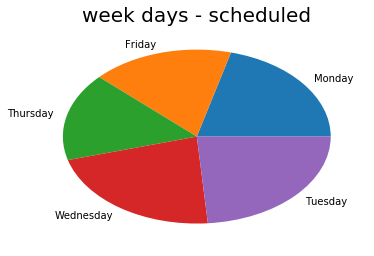

In [21]:
plt.pie([df['WeekdayScheduled'].value_counts()[1], df['WeekdayScheduled'].value_counts()[5], 
         df['WeekdayScheduled'].value_counts()[4], df['WeekdayScheduled'].value_counts()[3], df['WeekdayScheduled'].value_counts()[2]],
       labels=['Monday','Friday','Thursday','Wednesday','Tuesday'])
plt.title('week days - scheduled',fontsize=20)
plt.show()

Adding new column Appointment Day of week

In [22]:
df['weekday Appointment'] = df.apply(lambda x:x.AppointmentDay.isoweekday(),axis=1)

In [23]:
df['weekday Appointment'].value_counts()

3    25866
2    25637
1    22709
5    19015
4    17245
6       31
Name: weekday Appointment, dtype: int64

Appointments scheduled on Saturdays are very less compartive others So we will delete this values and they are no appointments booked on Sundays too.

In [24]:
df = df[df['weekday Appointment']<6]

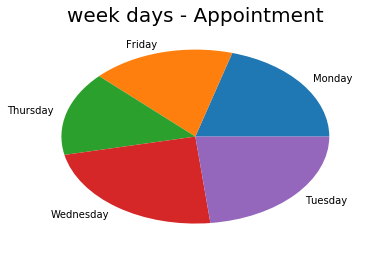

In [25]:
plt.pie([df['weekday Appointment'].value_counts()[1], df['weekday Appointment'].value_counts()[5], 
         df['weekday Appointment'].value_counts()[4], df['weekday Appointment'].value_counts()[3], df['weekday Appointment'].value_counts()[2]],
       labels=['Monday','Friday','Thursday','Wednesday','Tuesday'])
plt.title('week days - Appointment',fontsize=20)
plt.show()

#### Age

In [26]:
df['Age'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99])

count    110472.000000
mean         37.083768
std          23.110239
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
90%          68.000000
99%          86.000000
max         115.000000
Name: Age, dtype: float64

In [27]:
df[df['Age']<0]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientAppointments,IsMale,WeekdayScheduled,weekday Appointment
AppointmentID,,,,,,,,,,,,,,,,,
5775010,465943158731293,F,2016-06-06 08:58:13+00:00,2016-06-06 00:00:00+00:00,-1,ROMÃO,0,0,0,0,0,0,No,0,0,1,1


we can observe outliers sudden change in 99% to 100%
we will plot a violin plot where we can find outliers

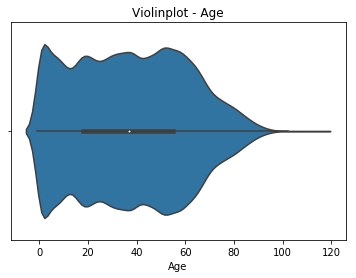

In [28]:
ax = sns.violinplot(df['Age'])
plt.title('Violinplot - Age')
plt.show()

In [29]:
value = df['Age'].quantile(0.9999)

In [30]:
value

98.95289999998931

In [31]:
df[df['Age']>98.9]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientAppointments,IsMale,WeekdayScheduled,weekday Appointment
AppointmentID,,,,,,,,,,,,,,,,,
5651757,976294799775439,F,2016-05-03 09:14:53+00:00,2016-05-03 00:00:00+00:00,102,CONQUISTA,0,0,0,0,0,0,No,0,0,2,2
5700278,31963211613981,F,2016-05-16 09:17:44+00:00,2016-05-19 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,Yes,1,0,1,4
5700279,31963211613981,F,2016-05-16 09:17:44+00:00,2016-05-19 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,Yes,2,0,1,4
5562812,31963211613981,F,2016-04-08 14:29:17+00:00,2016-05-16 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,Yes,0,0,5,1
5744037,31963211613981,F,2016-05-30 09:44:51+00:00,2016-05-30 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,No,3,0,1,1
5747809,9739429797896,M,2016-05-30 16:21:56+00:00,2016-05-31 00:00:00+00:00,100,TABUAZEIRO,0,0,0,0,1,0,No,0,1,1,2
5747808,9739429797896,M,2016-05-30 16:21:56+00:00,2016-05-31 00:00:00+00:00,100,TABUAZEIRO,0,0,0,0,1,0,No,1,1,1,2
5751563,234283596548,F,2016-05-31 10:19:49+00:00,2016-06-02 00:00:00+00:00,102,MARIA ORTIZ,0,0,0,0,0,0,No,0,0,2,4
5670914,55783129426615,F,2016-05-06 14:55:36+00:00,2016-06-03 00:00:00+00:00,100,ANTÔNIO HONÓRIO,0,0,0,0,0,1,No,0,0,5,5


#### Scholarship

In [32]:
df['Scholarship'].value_counts()

0    99615
1    10857
Name: Scholarship, dtype: int64

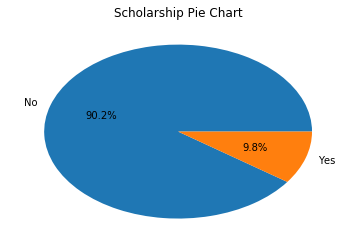

In [33]:
plt.pie([df['Scholarship'].value_counts()[0],df['Scholarship'].value_counts()[1]],labels=['No','Yes'],autopct='%1.1f%%')
plt.title('Scholarship Pie Chart')
plt.show()

#### Hipertension

In [34]:
df['Hipertension'].value_counts()

0    88691
1    21781
Name: Hipertension, dtype: int64

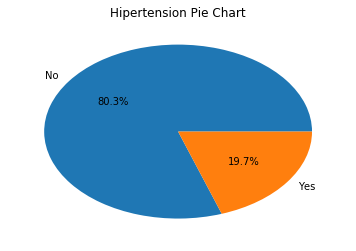

In [35]:
plt.pie([df['Hipertension'].value_counts()[0],df['Hipertension'].value_counts()[1]],labels=['No','Yes'],autopct='%1.1f%%')
plt.title('Hipertension Pie Chart')
plt.show()

#### Diabetes

In [36]:
df['Diabetes'].value_counts()

0    102538
1      7934
Name: Diabetes, dtype: int64

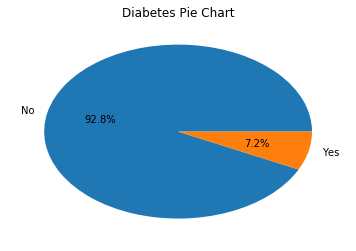

In [37]:
plt.pie([df['Diabetes'].value_counts()[0],df['Diabetes'].value_counts()[1]],labels=['No','Yes'],autopct='%1.1f%%')
plt.title('Diabetes Pie Chart')
plt.show()

#### Alcholism

In [38]:
df['Alcoholism'].value_counts()

0    107114
1      3358
Name: Alcoholism, dtype: int64

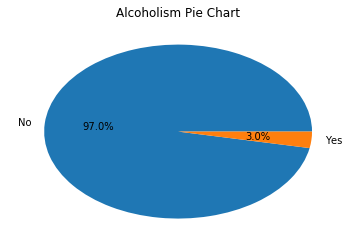

In [39]:
plt.pie([df['Alcoholism'].value_counts()[0],df['Alcoholism'].value_counts()[1]],labels=['No','Yes'],autopct='%1.1f%%')
plt.title('Alcoholism Pie Chart')
plt.show()

#### Handcap

In [40]:
df['Handcap'].value_counts()

0    108232
1      2041
2       183
3        13
4         3
Name: Handcap, dtype: int64

Handcap 1,2,3,4 categories are all handcaped so adding a newcolumn whether it is handcap or not

In [41]:
df['HasHandcap']=(df['Handcap']>0)*1

In [42]:
df['HasHandcap'].value_counts()

0    108232
1      2240
Name: HasHandcap, dtype: int64

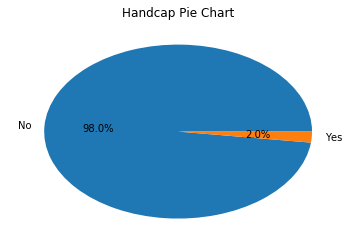

In [43]:
plt.pie([df['HasHandcap'].value_counts()[0],df['HasHandcap'].value_counts()[1]],labels=['No','Yes'],autopct='%1.1f%%')
plt.title('Handcap Pie Chart')
plt.show()

#### SMS_Received

In [44]:
df['SMS_received'].value_counts()

0    75007
1    35465
Name: SMS_received, dtype: int64

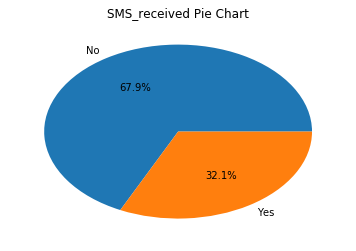

In [45]:
plt.pie([df['SMS_received'].value_counts()[0],df['SMS_received'].value_counts()[1]],labels=['No','Yes'],autopct='%1.1f%%')
plt.title('SMS_received Pie Chart')
plt.show()

Creating a new column in such a way whether the patient has history of diseases

In [49]:
df['HasHistoryDis'] = df.apply(lambda x: ((x.Hipertension == 1.0 ) or x.Diabetes == 1.0 or x.Alcoholism == 1.0)*1, axis = 1)

In [50]:
df.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientAppointments,IsMale,WeekdayScheduled,weekday Appointment,HasHandcap,HasHistoryDis
AppointmentID,,,,,,,,,,,,,,,,,,,
5642903,29872499824296,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,1,0,5,5,0,1
5642503,558997776694438,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,1,1,5,5,0,0
5642549,4262962299951,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,1,0,5,5,0,0
5642828,867951213174,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,1,0,5,5,0,0
5642494,8841186448183,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0,0,5,5,0,1


Calculating Number of Days before the appointment is done

In [51]:
def get_day(x):
    return x.date()

df['PriorNumberofDays'] = ((df.AppointmentDay.apply(get_day) - df.ScheduledDay.apply(get_day)).astype('timedelta64[D]'))

In [52]:
df['PriorNumberofDays'].value_counts()

 0.0      38555
 2.0       6714
 4.0       5285
 1.0       5212
 7.0       4906
 6.0       4037
 5.0       3274
 14.0      2913
 3.0       2729
 8.0       2331
 21.0      1861
 28.0      1706
 13.0      1681
 9.0       1601
 15.0      1503
 10.0      1390
 20.0      1185
 22.0      1173
 16.0      1151
 12.0      1110
 17.0      1107
 29.0      1089
 19.0      1044
 18.0      1021
 27.0      1013
 11.0       985
 35.0       963
 23.0       822
 34.0       808
 26.0       730
          ...  
 108.0        5
 95.0         5
 112.0        5
 103.0        5
 111.0        5
 119.0        4
 105.0        4
 102.0        4
-1.0          4
 96.0         4
 122.0        3
 92.0         3
 93.0         2
 97.0         2
 110.0        2
 94.0         2
 107.0        2
 115.0        2
 139.0        1
 125.0        1
 126.0        1
 151.0        1
 146.0        1
 101.0        1
 82.0         1
-6.0          1
 132.0        1
 117.0        1
 123.0        1
 127.0        1
Name: PriorNumberofDays,

There are some negative values which might be incorrect records

In [53]:
df[df['PriorNumberofDays']<0]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientAppointments,IsMale,WeekdayScheduled,weekday Appointment,HasHandcap,HasHistoryDis,PriorNumberofDays
AppointmentID,,,,,,,,,,,,,,,,,,,,
5679978,7839272661752,M,2016-05-10 10:51:53+00:00,2016-05-09 00:00:00+00:00,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,0,1,2,1,1,0,-1.0
5715660,7896293967868,F,2016-05-18 14:50:41+00:00,2016-05-17 00:00:00+00:00,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,4,0,3,2,1,0,-1.0
5664962,24252258389979,F,2016-05-05 13:43:58+00:00,2016-05-04 00:00:00+00:00,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,1,0,4,3,0,0,-1.0
5686628,998231581612122,F,2016-05-11 13:49:20+00:00,2016-05-05 00:00:00+00:00,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,1,0,3,4,0,0,-6.0
5655637,3787481966821,M,2016-05-04 06:50:57+00:00,2016-05-03 00:00:00+00:00,7,TABUAZEIRO,0,0,0,0,0,0,Yes,0,1,3,2,0,0,-1.0


In [54]:
df = df[df['PriorNumberofDays']>=0]

In [55]:
df['Noshow']=(df['No-show']=='Yes')*1

In [56]:
df.columns

Index(['PatientId', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age',
       'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes',
       'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientAppointments', 'IsMale', 'WeekdayScheduled',
       'weekday Appointment', 'HasHandcap', 'HasHistoryDis',
       'PriorNumberofDays', 'Noshow'],
      dtype='object')

In [57]:
df.shape

(110467, 21)

Converting catregorical values ScheduledDay,AppointmentDay to one-hot encoding values

In [58]:
df = df.assign(ScheduledMonday = (df['WeekdayScheduled'] == 1)*1, 
                         ScheduledTuesday = (df['WeekdayScheduled'] == 2)*1, 
                         ScheduledWednesday = (df['WeekdayScheduled'] == 3)*1,
                         ScheduledThursday = (df['WeekdayScheduled'] == 4)*1,
                         ScheduledFriday = (df['WeekdayScheduled'] == 5)*1)

In [59]:
df = df.assign(AppointmentMonday = (df['weekday Appointment'] == 1)*1, 
                         AppointmentTuesday = (df['weekday Appointment'] == 2)*1, 
                         AppointmentWednesday = (df['weekday Appointment'] == 3)*1,
                         AppointmentThursday = (df['weekday Appointment'] == 4)*1,
                         AppointmentFriday = (df['weekday Appointment'] == 5)*1)

In [60]:
df.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,...,ScheduledMonday,ScheduledTuesday,ScheduledWednesday,ScheduledThursday,ScheduledFriday,AppointmentMonday,AppointmentTuesday,AppointmentWednesday,AppointmentThursday,AppointmentFriday
AppointmentID,,,,,,,,,,,,,,,,,,,,,
5642903,29872499824296,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
5642503,558997776694438,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
5642549,4262962299951,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
5642828,867951213174,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
5642494,8841186448183,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,...,0,0,0,0,1,0,0,0,0,1


In [61]:
days_bef = df.groupby(['PriorNumberofDays'])[['No-show']].count()
days_bef.reset_index(inplace = True)
days_bef.columns = ['Days Ahead', 'Count']

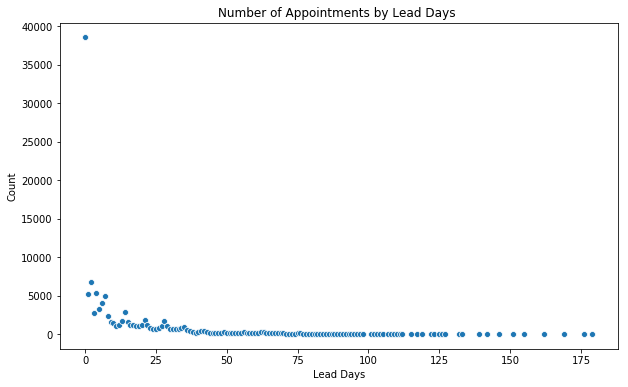

In [62]:
sns.scatterplot(x = 'Days Ahead', y = 'Count', data = days_bef)
plt.title('Number of Appointments by Lead Days ')
plt.xlabel('Lead Days')
plt.gcf().set_size_inches(10, 6)
plt.show()

In [63]:
def DaysBeforeApt(days):
    if days == 0:
        return '0 days'
    elif days in range(1,3):
        return '1-2 days'
    elif days in range(3,8):
        return '3-7 days'
    elif days in range(8, 32):
        return '8-31 days'
    else:
        return '> 31 days'

In [64]:
df['DaysBeforeApt'] = df.PriorNumberofDays.apply(DaysBeforeApt)

In [65]:
df['DaysBeforeApt'].value_counts()

0 days       38555
8-31 days    30051
3-7 days     20231
1-2 days     11926
> 31 days     9704
Name: DaysBeforeApt, dtype: int64

No-Show

In [66]:
df['No-show'].value_counts()

No     88163
Yes    22304
Name: No-show, dtype: int64

In [67]:
df['Noshow']=(df['No-show']=='Yes')*1

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110467 entries, 5642903 to 5629448
Data columns (total 32 columns):
PatientId               110467 non-null int64
Gender                  110467 non-null object
ScheduledDay            110467 non-null datetime64[ns, UTC]
AppointmentDay          110467 non-null datetime64[ns, UTC]
Age                     110467 non-null int64
Neighbourhood           110467 non-null object
Scholarship             110467 non-null int64
Hipertension            110467 non-null int64
Diabetes                110467 non-null int64
Alcoholism              110467 non-null int64
Handcap                 110467 non-null int64
SMS_received            110467 non-null int64
No-show                 110467 non-null object
PatientAppointments     110467 non-null int64
IsMale                  110467 non-null int64
WeekdayScheduled        110467 non-null int64
weekday Appointment     110467 non-null int64
HasHandcap              110467 non-null int64
HasHistoryDis          

### Previous appointment check

In [69]:
df['PreviousApp'] = df.sort_values(by = ['PatientId','ScheduledDay']).groupby(['PatientId']).cumcount()

### Previous Showup Count

In [70]:
df['PreviousNoShow'] = (df[df['PreviousApp'] > 0].sort_values(['PatientId', 'ScheduledDay']).groupby(['PatientId'])['Noshow'].cumsum() / df[df['PreviousApp'] > 0]['PreviousApp'])

In [71]:
df['PreviousNoShow'].head()

AppointmentID
5642903    0.0
5642503    0.0
5642549    0.0
5642828    0.0
5642494    NaN
Name: PreviousNoShow, dtype: float64

In [72]:
df.loc[:, 'Appointmentsmissed'] = df.sort_values(['WeekdayScheduled']).groupby(['PatientId'])['Noshow'].cumsum()

In [73]:
df['Appointmentsmissed'].value_counts()

0     76779
1     26192
2      5145
3      1378
4       495
5       210
6       100
7        59
8        35
9        19
10       19
11       12
12        7
13        6
14        4
15        3
16        2
17        1
18        1
Name: Appointmentsmissed, dtype: int64

In [74]:
def ant_days(df):
    df.loc[:, 'Ant0Days'] = (df['DaysBeforeApt'] == '0 days')*1
    df.loc[:, 'Ant12Days'] = (df['DaysBeforeApt'] == '1-2 days')*1
    df.loc[:, 'Ant37Days'] = (df['DaysBeforeApt'] == '3-7 days')*1
    df.loc[:, 'Ant831Days'] = (df['DaysBeforeApt'] == '8-31 days')*1
    df.loc[:, 'Ant32Days'] = (df['DaysBeforeApt'] == '> 31 days')*1
    
ant_days(df)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110467 entries, 5642903 to 5629448
Data columns (total 40 columns):
PatientId               110467 non-null int64
Gender                  110467 non-null object
ScheduledDay            110467 non-null datetime64[ns, UTC]
AppointmentDay          110467 non-null datetime64[ns, UTC]
Age                     110467 non-null int64
Neighbourhood           110467 non-null object
Scholarship             110467 non-null int64
Hipertension            110467 non-null int64
Diabetes                110467 non-null int64
Alcoholism              110467 non-null int64
Handcap                 110467 non-null int64
SMS_received            110467 non-null int64
No-show                 110467 non-null object
PatientAppointments     110467 non-null int64
IsMale                  110467 non-null int64
WeekdayScheduled        110467 non-null int64
weekday Appointment     110467 non-null int64
HasHandcap              110467 non-null int64
HasHistoryDis          

## Logistic regression

In [76]:
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model.logistic:

class LogisticRegression(sklearn.base.BaseEstimator, sklearn.linear_model.base.LinearClassifierMixin, sklearn.linear_model.base.SparseCoefMixin)
 |  LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='warn', max_iter=100, multi_class='warn', verbose=0, warm_start=False, n_jobs=None)
 |  
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the cross-
 |  entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 'sag' and 'lbfgs' solvers. It c

#### The dependent variable value is Binary classification so logistic regression is used when dependent varible is more than two classes we use softmax regression and not ordinal logistic regression too.

### Model Assumptions :

· Binary logistic regression requires the dependent variable to be binary. (This has met)
· For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.(this has met)
· Only the meaningful variables should be included.
· The independent variables should be independent of each other. That is, the model should have little or no multi-collinearity.(The model have less multi-collinearity)
· The independent variables are linearly related to the log odds.
· Logistic regression requires quite large sample sizes(Met)

In [111]:
df.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,...,AppointmentFriday,DaysBeforeApt,PreviousApp,PreviousNoShow,Appointmentsmissed,Ant0Days,Ant12Days,Ant37Days,Ant831Days,Ant32Days
AppointmentID,,,,,,,,,,,,,,,,,,,,,
5642903,29872499824296,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,...,1,0 days,1,0.0,0,1,0,0,0,0
5642503,558997776694438,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,...,1,0 days,1,0.0,0,1,0,0,0,0
5642549,4262962299951,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,...,1,0 days,1,0.0,0,1,0,0,0,0
5642828,867951213174,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,...,1,0 days,1,0.0,1,1,0,0,0,0
5642494,8841186448183,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,...,1,0 days,0,NaN,0,1,0,0,0,0


In [112]:
df.columns

Index(['PatientId', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age',
       'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes',
       'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientAppointments', 'IsMale', 'WeekdayScheduled',
       'weekday Appointment', 'HasHandcap', 'HasHistoryDis',
       'PriorNumberofDays', 'Noshow', 'ScheduledMonday', 'ScheduledTuesday',
       'ScheduledWednesday', 'ScheduledThursday', 'ScheduledFriday',
       'AppointmentMonday', 'AppointmentTuesday', 'AppointmentWednesday',
       'AppointmentThursday', 'AppointmentFriday', 'DaysBeforeApt',
       'PreviousApp', 'PreviousNoShow', 'Appointmentsmissed', 'Ant0Days',
       'Ant12Days', 'Ant37Days', 'Ant831Days', 'Ant32Days'],
      dtype='object')

In [113]:
features_vif = ['Age','Scholarship','Hipertension','Diabetes', 'Alcoholism', 'SMS_received',
             'HasHandcap', 'ScheduledMonday',
             'ScheduledTuesday', 'ScheduledWednesday', 'ScheduledThursday', 'ScheduledFriday',
             'AppointmentMonday', 'AppointmentTuesday', 'AppointmentWednesday',
             'AppointmentThursday', 'AppointmentFriday','PreviousApp','Appointmentsmissed',
             'IsMale', 'Ant0Days', 'Ant12Days',
             'Ant37Days', 'Ant831Days', 'Ant32Days','Noshow']

In [114]:
features = ['Age','Scholarship','Hipertension','Diabetes', 'Alcoholism', 'SMS_received',
             'HasHandcap', 'ScheduledMonday',
             'ScheduledTuesday', 'ScheduledWednesday', 'ScheduledThursday', 'ScheduledFriday',
             'AppointmentMonday', 'AppointmentTuesday', 'AppointmentWednesday',
             'AppointmentThursday', 'AppointmentFriday','PreviousApp','Appointmentsmissed',
             'IsMale', 'Ant0Days', 'Ant12Days',
             'Ant37Days', 'Ant831Days', 'Ant32Days']


In [118]:
scaler = StandardScaler().fit(df[features])
df_rescaled = scaler.transform(df[features])

X_train, X_test, y_train, y_test = train_test_split(df[features], df['Noshow'], test_size=0.33, random_state=42)
# y_train = pd.DataFrame(y_train)
# train = X_train.merge(y_train, left_index = True, right_index = True)
# y_test = pd.DataFrame(y_test)
# test = X_test.merge(y_test, left_index = True, right_index = True)

In [119]:
import statsmodels.api as sm

In [120]:
logml = sm.GLM(y_train,(sm.add_constant(X_train)),family = sm.families.Binomial())

In [121]:
logml.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Noshow   No. Observations:                74012
Model:                            GLM   Df Residuals:                    73989
Model Family:                Binomial   Df Model:                           22
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 25 Jul 2020   Deviance:                          nan
Time:                        02:25:18   Pearson chi2:                 9.68e+14
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.7556      0.024    -73.615      0.000      -1.802      -1.709
Age                     -0.0053      0.001     -7.517      0.000      -0.007      -0.004
Scholarship              0.1269      0.045      2.815      0.005       0.039       0.215
Hipertension            -0.0462      0.043     -1.070      0.285      -0.131       0.038
Diabetes                 0.0732      0.060      1.230      0.219      -0.043       0.190
Alcoholism               0.1350      0.085      1.595      0.111      -0.031       0.301
SMS_received            -0.1668      0.032     -5.222      0.000      -0.229      -0.104
HasHandcap              -0.1848      0.105     -1.759      0.079      -0.391       0.021
ScheduledMonday          0.1571      0.027      5.736      0.000       0.103       0.211
ScheduledTuesday        -0.0588      0.026     -2.292      0.022      -0.109      -0.009
ScheduledWednesday      -0.3535      0.027    -13.175      0.000      -0.406      -0.301
ScheduledThursday       -0.6320      0.031    -20.616      0.000      -0.692      -0.572
ScheduledFriday         -0.8685      0.032    -27.471      0.000      -0.930      -0.807
AppointmentMonday       -0.3246      0.029    -11.345      0.000      -0.381      -0.269
AppointmentTuesday      -0.2782      0.027    -10.415      0.000      -0.331      -0.226
AppointmentWednesday    -0.3287      0.026    -12.457      0.000      -0.380      -0.277
AppointmentThursday     -0.3850      0.031    -12.515      0.000      -0.445      -0.325
AppointmentFriday       -0.4391      0.030    -14.882      0.000      -0.497      -0.381
PreviousApp             -0.5037      0.011    -46.771      0.000      -0.525      -0.483
Appointmentsmissed       3.2596      0.027    120.725      0.000       3.207       3.313
IsMale                   0.0650      0.029      2.248      0.025       0.008       0.122
Ant0Days                -2.2625      0.040    -57.024      0.000      -2.340      -2.185
Ant12Days                0.0079      0.036      0.218      0.828      -0.063       0.079
Ant37Days                0.0036      0.029      0.123      0.902      -0.054       0.061
Ant831Days               0.2222      0.024      9.382      0.000       0.176       0.269
Ant32Days                0.2732      0.035      7.829      0.000       0.205       0.342
========================================================================================
"""

#### VIF(Variance Inflation Factor)

In [122]:
def vif_cal(input_data,dependent_col):
    vif_df=pd.DataFrame( columns = ['Var','Vif'])
    x_vars=input_data.drop([dependent_col],axis=1)
    xvar_names = x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]]
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-rsq),2)
        vif_df.loc[i]=[xvar_names[i],vif]
    return vif_df.sort_values(by='Vif', axis=0, ascending=False,inplace=False)

In [123]:
vif_cal(input_data=df[features_vif],dependent_col="Noshow")

,Var,Vif
12,AppointmentMonday,inf
11,ScheduledFriday,inf
23,Ant831Days,inf
22,Ant37Days,inf
21,Ant12Days,inf
20,Ant0Days,inf
16,AppointmentFriday,inf
15,AppointmentThursday,inf
14,AppointmentWednesday,inf
13,AppointmentTuesday,inf


The value in Vif is less than 2 for all independent variables ,  VIF values in excess of 5 or 10 are often considered an indication that multicollinearity may by a cause of problem in this case its not a problem

## Machine Learning Interpretiability


 ### Permutation Importance

In [124]:
from sklearn import metrics

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

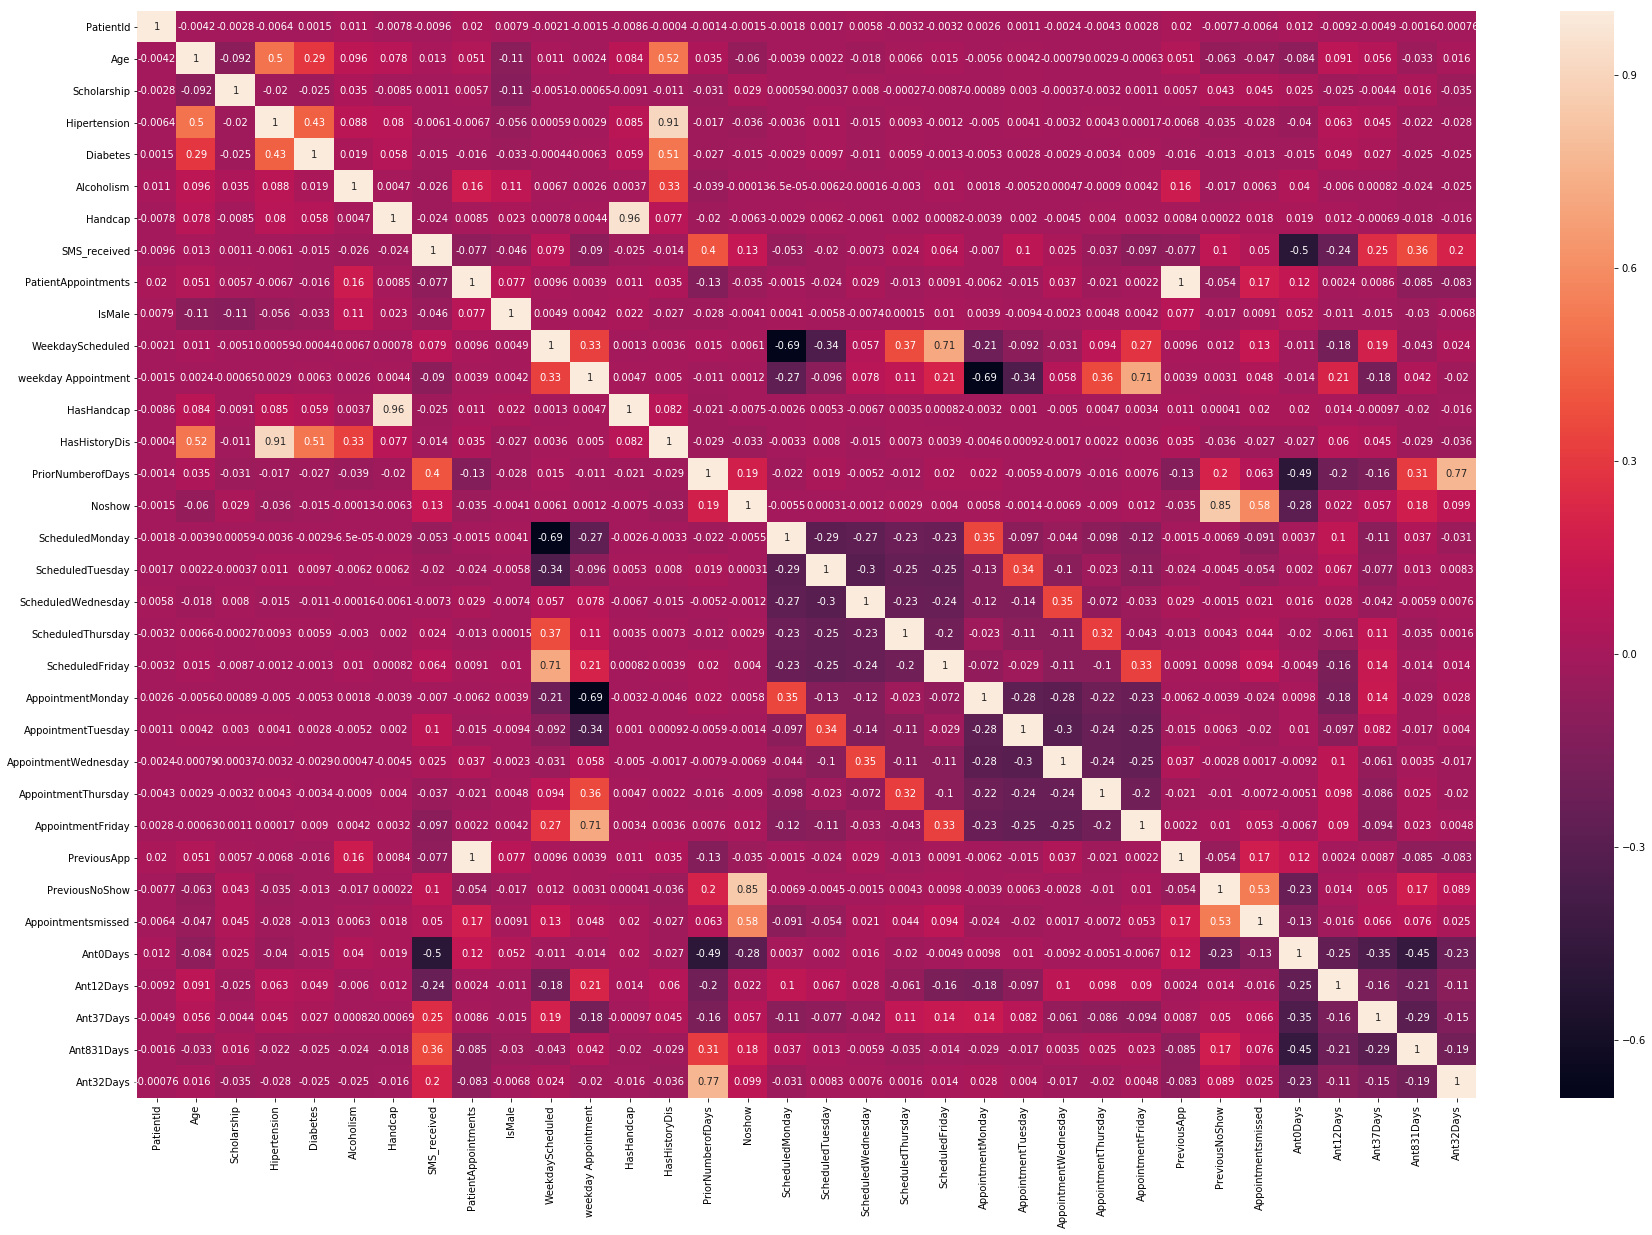

In [126]:
plt.figure(figsize=(30,20))
sns.heatmap(df.corr(),annot=True)

### From the co-relation matrix we can find that MissedAppointments,PriorNumberofDays,SMS_Received are most significant independent variables

In [127]:
logreg = LogisticRegression()

In [128]:
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [129]:
y_pred_log = logreg.predict(X_test)

In [130]:
print(accuracy_score(y_test,y_pred_log))

0.9217391304347826


In [131]:
confusion_matrix(y_test,y_pred_log)

array([[27650,  1434],
       [ 1419,  5952]])

In [132]:
roc_auc_score(y_test,y_pred_log)

0.8790916737210233

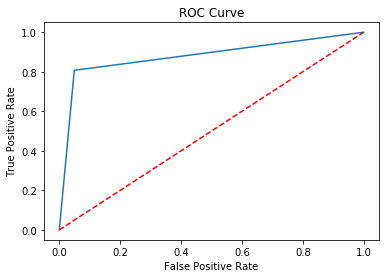

In [133]:
# ROC Curve 
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_log)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [134]:
pip install eli5

Note: you may need to restart the kernel to use updated packages.


In [135]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(logreg, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.2067 ± 0.0046,Appointmentsmissed
0.0383 ± 0.0012,Ant0Days
0.0260 ± 0.0018,PreviousApp
0.0057 ± 0.0009,ScheduledFriday
0.0042 ± 0.0011,ScheduledThursday
0.0031 ± 0.0008,ScheduledWednesday
0.0024 ± 0.0010,AppointmentThursday
0.0023 ± 0.0009,AppointmentFriday
0.0021 ± 0.0006,AppointmentWednesday
0.0016 ± 0.0006,Ant831Days


The values towards the top are the most important features, and those towards the bottom matter least.

The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

In [ ]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature='Goal Scored')

# plot it
pdp.pdp_plot(pdp_goals, 'Goal Scored')
plt.show()

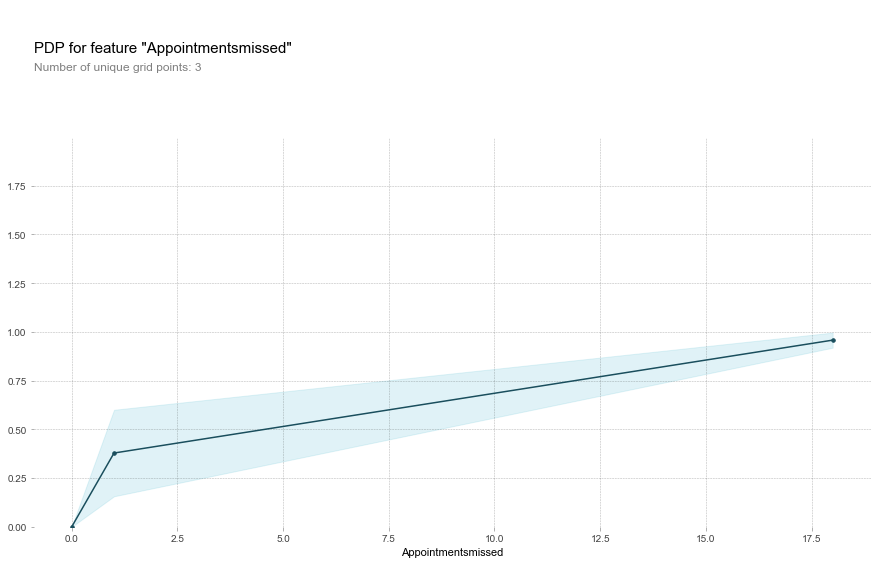

In [144]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_apt = pdp.pdp_isolate(model=logreg, dataset=X_test, model_features=features, feature='Appointmentsmissed')

# plot it
pdp.pdp_plot(pdp_apt, 'Appointmentsmissed')
plt.show()

## 2D Partial Dependency Plot

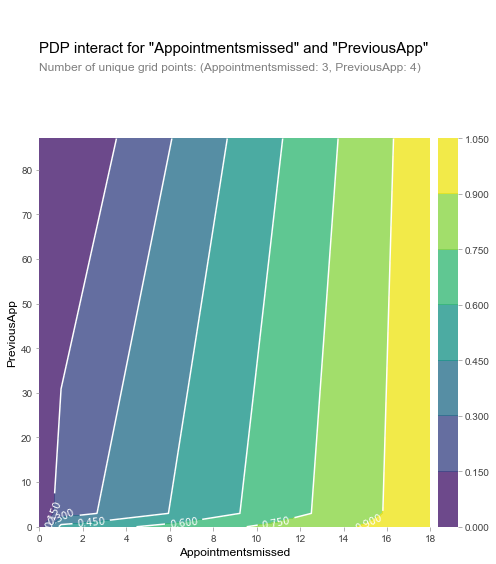

In [149]:
features_to_plot = ['Appointmentsmissed', 'PreviousApp']
inter1  =  pdp.pdp_interact(model=logreg, dataset=X_test, model_features=features, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

## SHAP

SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. Where could you use this?

A model says a bank shouldn't loan someone money, and the bank is legally required to explain the basis for each loan rejection

A healthcare provider wants to identify what factors are driving each patient's risk of some disease so they can directly address those risk factors with targeted health interventions



In [153]:
row_to_show = 5
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


logreg.predict_proba(data_for_prediction_array)

array([[0.98698922, 0.01301078]])

In [155]:
pip install shap

     |████████████████████████████████| 276kB 2.4MB/s eta 0:00:01
  Stored in directory: /Users/ikyathvarmadantuluri/Library/Caches/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
Note: you may need to restart the kernel to use updated packages.


In [181]:
y_model = RandomForestClassifier(random_state=0).fit(X_train, y_train)

In [182]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(y_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [183]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

### 2nd Model (removing high p value Independent variables)

In [162]:
features2 = ['Age', 'SMS_received','PriorNumberofDays','Appointmentsmissed']

In [163]:
scaler2 = StandardScaler().fit(df[features2])
df_rescaled2 = scaler2.transform(df[features2])

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df[features2], df['Noshow'], test_size=0.33, random_state=42)

In [164]:
logml2 = sm.GLM(y_train_2,(sm.add_constant(X_train_2)),family = sm.families.Binomial())

In [165]:
logml2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Noshow   No. Observations:                74012
Model:                            GLM   Df Residuals:                    74007
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 25 Jul 2020   Deviance:                          nan
Time:                        14:05:43   Pearson chi2:                 1.96e+13
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.1367      0.030   -104.260      0.000      -3.196      -3.078
Age                   -0.0067      0.001    -12.370      0.000      -0.008      -0.006
SMS_received           0.3478      0.026     13.365      0.000       0.297       0.399
PriorNumberofDays      0.0266      0.001     35.969      0.000       0.025       0.028
Appointmentsmissed     2.5973      0.022    118.809      0.000       2.554       2.640
======================================================================================
"""

In [166]:
logreg2 = LogisticRegression()

In [167]:
logreg2.fit(X_train_2,y_train_2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [168]:
y_pred_log_2 = logreg2.predict(X_test_2)

In [169]:
print(accuracy_score(y_test_2,y_pred_log_2))

0.8567274722260321


In [170]:
confusion_matrix(y_test_2,y_pred_log_2)

array([[27817,  1267],
       [ 3956,  3415]])

In [171]:
roc_auc_score(y_test_2,y_pred_log_2)

0.7098693293221786

In [172]:
roc_curve(y_test_2,y_pred_log_2)

(array([0.        , 0.04356347, 1.        ]),
 array([0.        , 0.46330213, 1.        ]),
 array([2, 1, 0], dtype=int64))

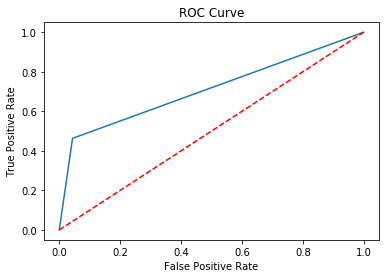

In [173]:
# ROC Curve 

fpr, tpr, threshold = metrics.roc_curve(y_test_2, y_pred_log_2)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

 After many trails Difference between Model 1 and Model2 are Ant12Days,Ant37Days

In [174]:
folds_log = StratifiedKFold(n_splits=5,shuffle = True,random_state=True)

In [175]:
hyper_params_log = [{'C':[0.001,0.01,0.1,1,10],'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]

In [176]:
logreg3 = LogisticRegression()

In [107]:
logreg3_GS = GridSearchCV(estimator=logreg3,param_grid=hyper_params_log,scoring='accuracy',cv=folds_log,verbose=1,return_train_score=True)

In [108]:
logreg3_GS.fit(X_train_2,y_train_2)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge",

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=True, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
           

In [109]:
logreg3_GS_results = pd.DataFrame(logreg3_GS.cv_results_)
logreg3_GS_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_solver,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.184919,0.009932,0.002005,0.000095,0.001,newton-cg,"{'C': 0.001, 'solver': 'newton-cg'}",0.831791,0.834966,0.829764,...,0.832433,0.001748,24,0.833725,0.831630,0.834012,0.832376,0.831332,0.832615,0.001082
1,0.110988,0.009282,0.002193,0.000513,0.001,lbfgs,"{'C': 0.001, 'solver': 'lbfgs'}",0.831791,0.834966,0.829764,...,0.832433,0.001748,24,0.833741,0.831630,0.834012,0.832376,0.831332,0.832618,0.001086
2,0.088372,0.006134,0.001860,0.000143,0.001,liblinear,"{'C': 0.001, 'solver': 'liblinear'}",0.840640,0.847666,0.841789,...,0.843796,0.002446,21,0.845040,0.843318,0.844145,0.843118,0.843475,0.843819,0.000701
3,0.342131,0.032429,0.002112,0.000194,0.001,sag,"{'C': 0.001, 'solver': 'sag'}",0.831858,0.834966,0.829832,...,0.832500,0.001716,22,0.833708,0.831647,0.834062,0.832376,0.831400,0.832639,0.001073
4,0.721796,0.013738,0.002123,0.000195,0.001,saga,"{'C': 0.001, 'solver': 'saga'}",0.831858,0.834898,0.829899,...,0.832500,0.001666,22,0.833775,0.831647,0.834079,0.832410,0.831366,0.832656,0.001097
5,0.199515,0.018168,0.001926,0.000127,0.01,newton-cg,"{'C': 0.01, 'solver': 'newton-cg'}",0.848882,0.851246,0.847126,...,0.850092,0.001808,17,0.851982,0.848807,0.851610,0.849772,0.848187,0.850072,0.001501
6,0.114566,0.007792,0.001861,0.000156,0.01,lbfgs,"{'C': 0.01, 'solver': 'lbfgs'}",0.848882,0.851246,0.847126,...,0.850092,0.001808,17,0.851982,0.848807,0.851610,0.849772,0.848187,0.850072,0.001501
7,0.097885,0.002789,0.001802,0.000115,0.01,liblinear,"{'C': 0.01, 'solver': 'liblinear'}",0.849760,0.853273,0.848679,...,0.851362,0.001808,16,0.853215,0.849753,0.852810,0.850988,0.849167,0.851186,0.001608
8,0.813685,0.193804,0.003283,0.000648,0.01,sag,"{'C': 0.01, 'solver': 'sag'}",0.848612,0.851314,0.847193,...,0.850051,0.001821,19,0.851948,0.848857,0.851712,0.849789,0.848255,0.850112,0.001487
9,1.424124,0.050984,0.003989,0.000152,0.01,saga,"{'C': 0.01, 'solver': 'saga'}",0.848274,0.851314,0.846855,...,0.849889,0.001952,20,0.851729,0.848638,0.851577,0.849755,0.848103,0.849960,0.001482


### Best hyper parameters found out by doing GridSearch Cross validation are mentioned below

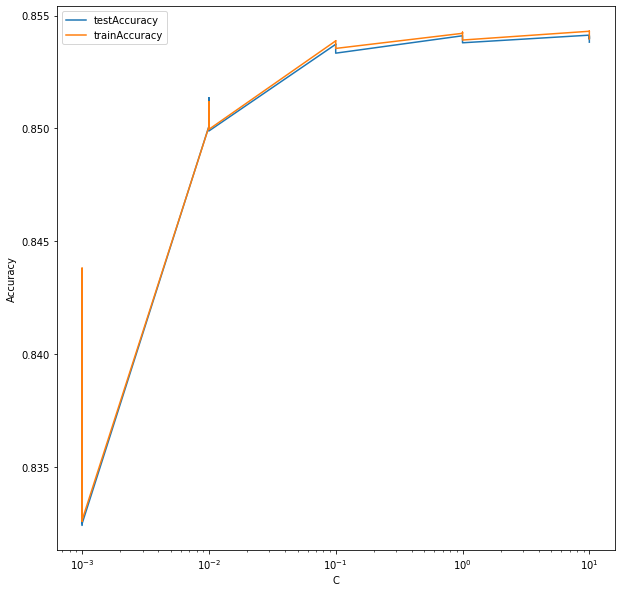

In [110]:
plt.figure(figsize=(10,10))
plt.plot(logreg3_GS_results['param_C'],logreg3_GS_results['mean_test_score'])
plt.plot(logreg3_GS_results['param_C'],logreg3_GS_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(['testAccuracy','trainAccuracy'], loc='upper left')
plt.xscale('log')

In [111]:
logreg3_GS.best_params_

{'C': 10, 'solver': 'newton-cg'}

In [112]:
logreg4 = LogisticRegression(C=10,solver='liblinear')

In [113]:
logreg4.fit(X_train_2,y_train_2)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [114]:
y_pred_log_4 = logreg4.predict(X_test_2)

In [115]:
print(accuracy_score(y_test_2,y_pred_log_4))

0.856754903305445


In [116]:
confusion_matrix(y_test_2,y_pred_log_4)

array([[27816,  1268],
       [ 3954,  3417]])

In [117]:
roc_auc_score(y_test_2,y_pred_log_4)

0.7099878045415111

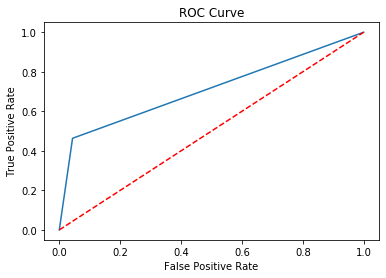

In [118]:
# ROC Curve 
fpr, tpr, threshold = metrics.roc_curve(y_test_2, y_pred_log_4)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Hyperparameters C and solver are important for logistic regression

### Significant variables are : AppointmentsMissed,PriorNumberofDays before appointment is booked and SMS_receieved

## SVM

The margin should be as large as possible.
The support vectors are the most useful data points because they are the ones most likely to be incorrectly classified.

In [177]:
help(LinearSVC)

Help on class LinearSVC in module sklearn.svm.classes:

class LinearSVC(sklearn.base.BaseEstimator, sklearn.linear_model.base.LinearClassifierMixin, sklearn.linear_model.base.SparseCoefMixin)
 |  LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)
 |  
 |  Linear Support Vector Classification.
 |  
 |  Similar to SVC with parameter kernel='linear', but implemented in terms of
 |  liblinear rather than libsvm, so it has more flexibility in the choice of
 |  penalties and loss functions and should scale better to large numbers of
 |  samples.
 |  
 |  This class supports both dense and sparse input and the multiclass support
 |  is handled according to a one-vs-the-rest scheme.
 |  
 |  Read more in the :ref:`User Guide <svm_classification>`.
 |  
 |  Parameters
 |  ----------
 |  penalty : string, 'l1' or 'l2' (default='l2')
 |      Specifie

SVM Assumptions :

In [178]:
model_SVM = LinearSVC(C=1)

In [179]:
model_SVM.fit(X_train_2,y_train_2)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [122]:
y_pred_s = model_SVM.predict(X_test_2)

In [123]:
confusion_matrix(y_test,y_pred_s)

array([[27002,  2082],
       [ 3186,  4185]])

In [124]:
accuracy_score(y_test,y_pred_s)

0.8554930736524482

In [125]:
roc_auc_score(y_test,y_pred_s)

0.7480899080747795

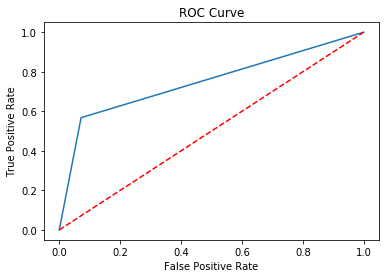

In [126]:
# ROC Curve 
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_s)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Hyperparameter Tuning

In [127]:
folds = KFold(n_splits=5,shuffle = True,random_state=True)

Penalty parameter C of the error term

In [128]:
params = {'C':[0.01,0.1,1,10,100],'loss':['hinge','squared_hinge']}

In [129]:
model_SVM_2 = LinearSVC()

In [130]:
model_SVM_GS = GridSearchCV(estimator=model_SVM_2,param_grid=params,scoring='accuracy',cv=folds,verbose=1,return_train_score=True)

In [131]:
model_SVM_GS.fit(X_train_2,y_train_2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ikya

/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.9min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=True, shuffle=True),
             error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'loss': ['hinge', 'squared_hinge']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

In [132]:
SVM_GS_results = pd.DataFrame(model_SVM_GS.cv_results_)
SVM_GS_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_loss,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.675274,0.026103,0.004783,0.000418,0.01,hinge,"{'C': 0.01, 'loss': 'hinge'}",0.896372,0.901506,0.894676,...,0.896193,0.002807,1,0.896148,0.894864,0.896572,0.896521,0.896859,0.896193,0.000702
1,6.143343,0.364596,0.004464,0.000232,0.01,squared_hinge,"{'C': 0.01, 'loss': 'squared_hinge'}",0.832737,0.829359,0.830699,...,0.831811,0.001523,5,0.830549,0.831664,0.832123,0.833153,0.831346,0.831767,0.000862
2,4.661580,0.167257,0.004005,0.000247,0.1,hinge,"{'C': 0.1, 'loss': 'hinge'}",0.896372,0.901506,0.894676,...,0.896193,0.002807,1,0.896148,0.894864,0.896572,0.896521,0.896859,0.896193,0.000702
3,5.652292,0.181585,0.004230,0.000130,0.1,squared_hinge,"{'C': 0.1, 'loss': 'squared_hinge'}",0.839424,0.831183,0.828739,...,0.829176,0.006978,6,0.837964,0.833269,0.830485,0.818848,0.827918,0.829697,0.006365
4,5.442229,0.170317,0.004433,0.000400,1,hinge,"{'C': 1, 'loss': 'hinge'}",0.875025,0.836317,0.895082,...,0.879614,0.023085,3,0.877975,0.839197,0.894156,0.896116,0.897720,0.881033,0.022081
5,6.264233,0.162823,0.004432,0.000320,1,squared_hinge,"{'C': 1, 'loss': 'squared_hinge'}",0.815240,0.816726,0.826037,...,0.818354,0.004602,7,0.813643,0.819301,0.827225,0.814204,0.818173,0.818509,0.004877
6,6.291546,0.038537,0.004338,0.000183,10,hinge,"{'C': 10, 'loss': 'hinge'}",0.822131,0.831318,0.862519,...,0.840323,0.018142,4,0.819031,0.835937,0.867168,0.864347,0.821094,0.841515,0.020654
7,6.139857,0.286642,0.004230,0.000675,10,squared_hinge,"{'C': 10, 'loss': 'squared_hinge'}",0.801121,0.549483,0.835901,...,0.760836,0.106364,8,0.797142,0.557804,0.839098,0.806350,0.808107,0.761700,0.102925
8,2.745342,0.382657,0.002342,0.000162,100,hinge,"{'C': 100, 'loss': 'hinge'}",0.816591,0.343579,0.802189,...,0.702927,0.182908,10,0.813525,0.350183,0.801267,0.824270,0.730704,0.703990,0.179900
9,2.409094,0.044758,0.002259,0.000142,100,squared_hinge,"{'C': 100, 'loss': 'squared_hinge'}",0.821523,0.809160,0.508242,...,0.753445,0.122721,9,0.821446,0.812765,0.500068,0.809424,0.816737,0.752088,0.126074


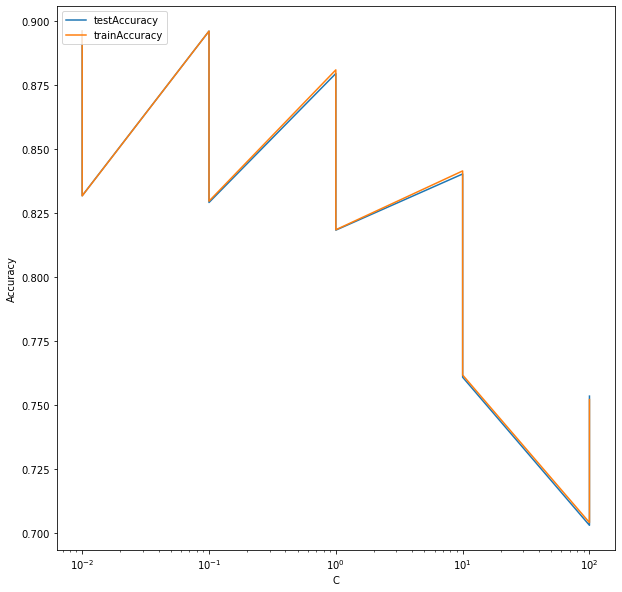

In [133]:
plt.figure(figsize=(10,10))
plt.plot(SVM_GS_results['param_C'],SVM_GS_results['mean_test_score'])
plt.plot(SVM_GS_results['param_C'],SVM_GS_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(['testAccuracy','trainAccuracy'], loc='upper left')
plt.xscale('log')


### Best hyper parameters found out by doing GridSearch Cross validation below are the best hyper parameters

In [134]:
model_SVM_GS.best_params_

{'C': 0.01, 'loss': 'hinge'}

#### Cross Validation

In [135]:
model_SVM_1 = LinearSVC(C=1,loss='hinge')

In [136]:
cv_results = cross_val_score(model_SVM_1,X_train_2,y_train_2,cv=folds,scoring='accuracy')

/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: C

In [137]:
print(cv_results)

[0.88218604 0.8605688  0.90089177 0.89663559 0.88852858]


In [138]:
print("mean_accuracy={}".format(cv_results.mean()))

mean_accuracy=0.8857621570754359


### Hyperparameters C  is important for linear Support vector classifier

## Decision Tree

The below are the some of the assumptions we make while using Decision tree:  


At the beginning, the whole training set is considered as the root. 

Feature values are preferred to be categorical. If the values are continuous then they are discretized prior to building the model.

Records are distributed recursively on the basis of attribute values.

Order to placing attributes as root or internal node of the tree is done by using some statistical approach which are below mention.

In [139]:
shallow_tree = DecisionTreeClassifier(max_depth=2, random_state=100)

In [140]:
shallow_tree.fit(X_train_2,y_train_2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

In [141]:
y_pred_tree = shallow_tree.predict(X_test_2)

In [142]:
score = accuracy_score(y_test_2,y_pred_tree)
score
confusion_matrix(y_test_2,y_pred_tree)

array([[26899,  2185],
       [  588,  6783]])

In [143]:
score

0.9239336167878206

In [144]:
roc_auc_score(y_test_2,y_pred_tree)

0.9225503512568565

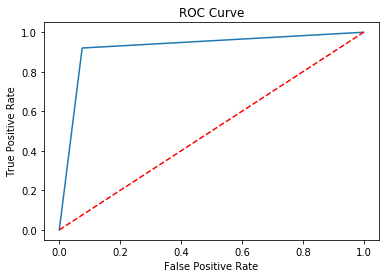

In [145]:
# ROC Curve 
fpr, tpr, threshold = metrics.roc_curve(y_test_2, y_pred_tree)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### ADA Boost

In [146]:
estimators = list(range(1,50,3))

In [147]:
abc_scores = []
for n_test in estimators:
    ABC = AdaBoostClassifier(base_estimator=shallow_tree,n_estimators=n_test)
    
    ABC.fit(X_train_2,y_train_2)
    y_pred_tree = ABC.predict(X_test_2)
    score_tree = accuracy_score(y_test_2,y_pred_tree)
    abc_scores.append(score_tree)

In [148]:
abc_scores

[0.9239336167878206,
 0.9250857221231655,
 0.9250857221231655,
 0.9250308599643396,
 0.9250308599643396,
 0.9250582910437526,
 0.9250582910437526,
 0.9249485667261007,
 0.9248388424084488,
 0.9248114113290358,
 0.9248662734878618,
 0.9249485667261007,
 0.9251680153614045,
 0.9249211356466877,
 0.9248937045672747,
 0.9248662734878618,
 0.9250857221231655]

In [149]:
abc_scores[12]

0.9251680153614045

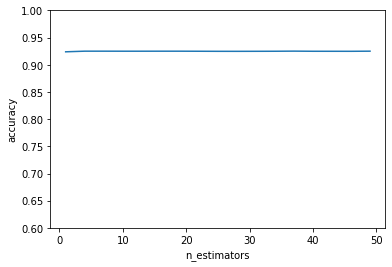

In [150]:
plt.plot(estimators,abc_scores)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.ylim([0.6,1])
plt.show()

### Gradient Boost Classifer

In [151]:
param_GB={"learning_rate":[0.2,0.6,0.9],"subsample":[0.3,0.6,0.9]}

In [152]:
folds_GB = 3
GBC = GradientBoostingClassifier()
gridsearch_GB = GridSearchCV(GBC,cv=folds_GB,param_grid=param_GB,scoring='accuracy',return_train_score=True,verbose=1)
gridsearch_GB.fit(X_train_2,y_train_2)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   40.4s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [153]:
GBC_results = pd.DataFrame(gridsearch_GB.cv_results_)
GBC_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.386755,0.010484,0.027364,0.000670,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.925135,0.923716,0.923470,0.924107,0.000734,3,0.924464,0.925376,0.925966,0.925269,0.000618
1,1.661499,0.013056,0.026930,0.000528,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.925256,0.923878,0.923429,0.924188,0.000777,2,0.924424,0.925822,0.925844,0.925363,0.000664
2,1.446158,0.013003,0.026141,0.000318,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.925297,0.923919,0.923510,0.924242,0.000764,1,0.924525,0.925620,0.925804,0.925316,0.000564
3,1.378899,0.008551,0.024382,0.000784,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.925094,0.922865,0.922700,0.923553,0.001092,4,0.923431,0.925072,0.925115,0.924539,0.000784
4,1.683255,0.015065,0.028778,0.000369,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.924689,0.923270,0.922537,0.923499,0.000893,6,0.925437,0.926045,0.926959,0.926147,0.000625
5,1.355628,0.033262,0.023264,0.001168,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.924527,0.923270,0.922740,0.923512,0.000749,5,0.925843,0.927282,0.927547,0.926890,0.000749
6,1.165379,0.034774,0.019721,0.000531,0.9,0.3,"{'learning_rate': 0.9, 'subsample': 0.3}",0.921730,0.921041,0.920349,0.921040,0.000564,9,0.923492,0.922803,0.923412,0.923235,0.000308
7,1.470397,0.006026,0.024551,0.000450,0.9,0.6,"{'learning_rate': 0.9, 'subsample': 0.6}",0.924203,0.922297,0.922294,0.922931,0.000899,8,0.925316,0.924586,0.926756,0.925553,0.000902
8,1.273311,0.024749,0.024588,0.000369,0.9,0.9,"{'learning_rate': 0.9, 'subsample': 0.9}",0.923716,0.922946,0.922456,0.923040,0.000518,7,0.926349,0.927140,0.927607,0.927032,0.000519


### Best Hyperparameters for GradientBoosting are below :

In [154]:
gridsearch_GB.best_params_

{'learning_rate': 0.2, 'subsample': 0.9}

In [155]:
GBC_best = GradientBoostingClassifier(learning_rate=0.2,subsample=0.9)

In [156]:
GBC_best.fit(X_train_2,y_train_2)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [157]:
y_pred_GBC = GBC_best.predict(X_test_2)
print(accuracy_score(y_test_2,y_pred_GBC))

0.9252777396790564


In [158]:
roc_auc_score(y_test_2,y_pred_GBC)

0.9255196951868663

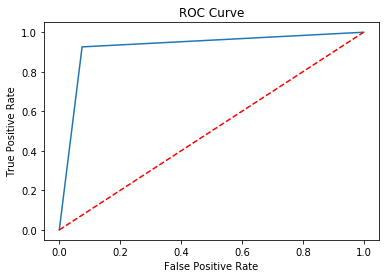

In [159]:
# ROC Curve 
fpr, tpr, threshold = metrics.roc_curve(y_test_2, y_pred_GBC)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Significant hyper parameters for GradientBoosting are learning rate and sub sample

### Random Forest

In [160]:
RFModel = RandomForestClassifier()


In [161]:
RFModel.fit(X_train_2,y_train_2)

/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [162]:
y_pred_rf = RFModel.predict(X_test_2)

In [163]:
score = accuracy_score(y_test_2,y_pred_rf)
score


0.9091482649842272

In [164]:
confusion_matrix(y_test_2,y_pred_rf)

array([[27288,  1796],
       [ 1516,  5855]])

In [165]:
roc_auc_score(y_test_2,y_pred_rf)

0.8662884807615013

### Hyperparameter Tuning

In [166]:
folds_rf = StratifiedKFold(n_splits=5,shuffle = True,random_state=True)

In [167]:
params_rf = {'n_estimators':[40,50],'min_samples_split':[30,40,50]}

In [168]:
model_RF_GS = GridSearchCV(estimator=RFModel,param_grid=params_rf,scoring='accuracy',cv=folds_rf,verbose=1,return_train_score=True)

In [169]:
model_RF_GS.fit(X_train_2,y_train_2)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   22.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=True, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
             

In [170]:
RF_GS_results = pd.DataFrame(model_RF_GS.cv_results_)
RF_GS_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.514192,0.015027,0.038489,0.001282,30,40,"{'min_samples_split': 30, 'n_estimators': 40}",0.917854,0.924745,0.920219,...,0.922958,0.003339,6,0.930484,0.929065,0.929960,0.928880,0.928476,0.929373,0.000738
1,0.629479,0.033901,0.046110,0.001931,30,50,"{'min_samples_split': 30, 'n_estimators': 50}",0.918327,0.925421,0.920422,...,0.923350,0.003406,5,0.930636,0.928828,0.929876,0.929252,0.928324,0.929383,0.000807
2,0.494341,0.012384,0.037322,0.001195,40,40,"{'min_samples_split': 40, 'n_estimators': 40}",0.919408,0.925961,0.921367,...,0.923877,0.002960,4,0.929335,0.927427,0.928845,0.927715,0.927378,0.928140,0.000799
3,0.605061,0.017091,0.045705,0.002362,40,50,"{'min_samples_split': 40, 'n_estimators': 50}",0.919273,0.926839,0.921232,...,0.924066,0.003225,2,0.929335,0.927224,0.928541,0.927782,0.927632,0.928103,0.000749
4,0.504577,0.027401,0.036389,0.000541,50,40,"{'min_samples_split': 50, 'n_estimators': 40}",0.919611,0.926164,0.921638,...,0.924201,0.003005,1,0.928659,0.926633,0.927781,0.926887,0.926720,0.927336,0.000778
5,0.610826,0.026276,0.045243,0.000504,50,50,"{'min_samples_split': 50, 'n_estimators': 50}",0.919611,0.926434,0.920624,...,0.924039,0.003283,3,0.928626,0.926599,0.927680,0.926854,0.926652,0.927282,0.000776


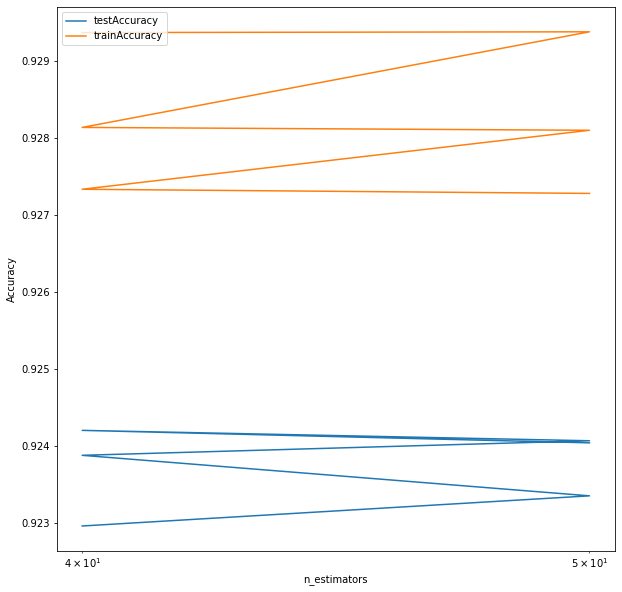

In [171]:
plt.figure(figsize=(10,10))
plt.plot(RF_GS_results['param_n_estimators'],RF_GS_results['mean_test_score'])
plt.plot(RF_GS_results['param_n_estimators'],RF_GS_results['mean_train_score'])
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend(['testAccuracy','trainAccuracy'], loc='upper left')
plt.xscale('log')

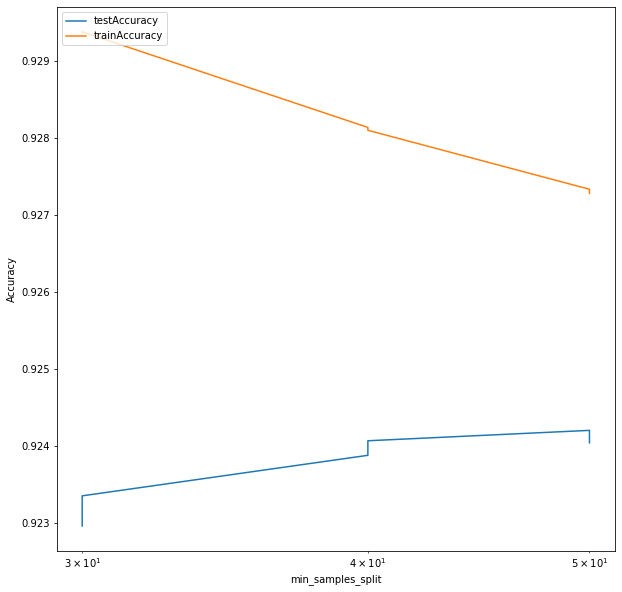

In [172]:
plt.figure(figsize=(10,10))
plt.plot(RF_GS_results['param_min_samples_split'],RF_GS_results['mean_test_score'])
plt.plot(RF_GS_results['param_min_samples_split'],RF_GS_results['mean_train_score'])
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.legend(['testAccuracy','trainAccuracy'], loc='upper left')
plt.xscale('log')

In [173]:
model_RF_GS.best_params_

{'min_samples_split': 50, 'n_estimators': 40}

### RF Best Hyperparameters model 

In [174]:
RFModel_2 = RandomForestClassifier(n_estimators=50,min_samples_split=30)

In [175]:
RFModel_2.fit(X_train_2,y_train_2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [176]:
y_pred_rf_2 = RFModel_2.predict(X_test_2)

In [177]:
print(accuracy_score(y_test_2,y_pred_rf_2))


0.923604443834865


In [178]:
X_train_2

,Age,SMS_received,PriorNumberofDays,Appointmentsmissed
AppointmentID,,,,
5634803,31,0,18.0,0
5628205,1,0,13.0,2
5781008,49,0,0.0,0
5631925,46,1,4.0,0
5660127,77,0,0.0,0
5712321,48,0,0.0,0
5753694,8,0,2.0,0
5715666,9,0,0.0,0
5786452,22,0,0.0,0


In [179]:
pickle.dump(RFModel_2,open('model.pkl','wb'))

In [180]:
model = pickle.load(open('model.pkl','rb'))

In [181]:
print(model.predict([[37,0,14,1]]))

[1]


In [182]:
confusion_matrix(y_test_2,y_pred_rf_2)

array([[26972,  2112],
       [  673,  6698]])

In [183]:
roc_auc_score(y_test_2,y_pred_rf_2)

0.9180394977167544

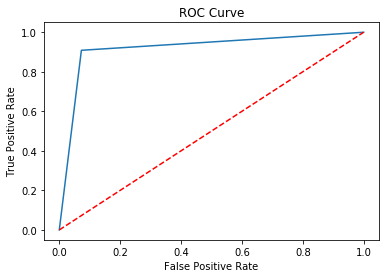

In [184]:
# ROC Curve 
fpr, tpr, threshold = metrics.roc_curve(y_test_2, y_pred_rf_2)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Significant hyper parameters for GradientBoosting are learning rate and sub sample

## Model Comparsions:

After hyperparameter tuning random forest algorithm has outperformed other algorithms with comparsion in accuracy score

## Naive Bayes

#### The Naive Bayes Algorithm is called Naive because it makes the assumption that the occurence of certain features is independent of other features

In [185]:
from sklearn.naive_bayes import GaussianNB

In [186]:
gnb = GaussianNB()

In [187]:
gnb.fit(X_train_2,y_train_2)

GaussianNB(priors=None, var_smoothing=1e-09)

In [188]:
y_pred_gnb = gnb.predict(X_test_2)

In [189]:
print(accuracy_score(y_test_2,y_pred_gnb))

0.8265532848717597


In [190]:
confusion_matrix(y_test_2,y_pred_gnb)

array([[27637,  1447],
       [ 4876,  2495]])

In [191]:
roc_auc_score(y_test_2,y_pred_GBC)

0.9255196951868663

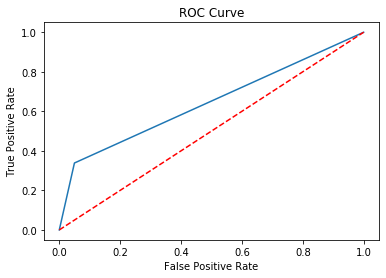

In [192]:
# ROC Curve 
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_gnb)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [193]:
estimators_NB = list(range(1,20,2))

In [194]:
abc_scores_NB = []
for n_test in estimators:
    ABC_NB = AdaBoostClassifier(base_estimator=gnb,n_estimators=n_test)
    
    ABC_NB.fit(X_train_2,y_train_2)
    y_pred_NB = ABC_NB.predict(X_test_2)
    score_tree = accuracy_score(y_test_2,y_pred_NB)
    abc_scores_NB.append(score_tree)

In [195]:
abc_scores_NB

[0.8265532848717597,
 0.812014812782883,
 0.8856398299273076,
 0.7976683582498971,
 0.8529694143464546,
 0.8102317926210396,
 0.807570977917981,
 0.7979426690440269,
 0.797832944726375,
 0.7979426690440269,
 0.797832944726375,
 0.7979426690440269,
 0.797832944726375,
 0.7979426690440269,
 0.797832944726375,
 0.7979426690440269,
 0.797832944726375]

### Conclusion

Feature named MissedAppointments which was not present in dataset initially,After figuring it out, found it has the most corelated feature to the dependent variable, it makes sense that behavior of previous instances is helpful to predict the current instance whether the patient is going to showup or not.

## License

Copyright 2020 Satya Ikyath Varma Dantuluri

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.